The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# subfolder = "wind_near_wall_bemt_in_control_train_x_only_wind"
# subfolder = "wind_near_wall_bemt_in_control_train_z_only_wind"
# subfolder = "wind_near_wall_bemt_in_control_train_xz_wind"
subfolder = "nf_training_back2back"
folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Filter out files that do not end with .csv
file_names = [f for f in file_names if f.endswith('.csv')]
# add subfolder to the file names
data_list = [os.path.join(subfolder, f) for f in file_names]
for data in data_list:
    print(data)

path1 = os.path.join(subfolder, "input_label_map_disturbance_force_label.yaml")
path2 = os.path.join(subfolder, "column_map.yaml")

nf_training_back2back\custom_random3_baseline_10wind_converted.csv
nf_training_back2back\custom_random3_baseline_20wind_converted.csv
nf_training_back2back\custom_random3_baseline_30wind_converted.csv
nf_training_back2back\custom_random3_baseline_40wind_converted.csv
nf_training_back2back\custom_random3_baseline_50wind_converted.csv
nf_training_back2back\custom_random3_baseline_nowind_converted.csv


- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Loading normalization params file from
..\data\training\nf_training_back2back\normalization_params.yaml


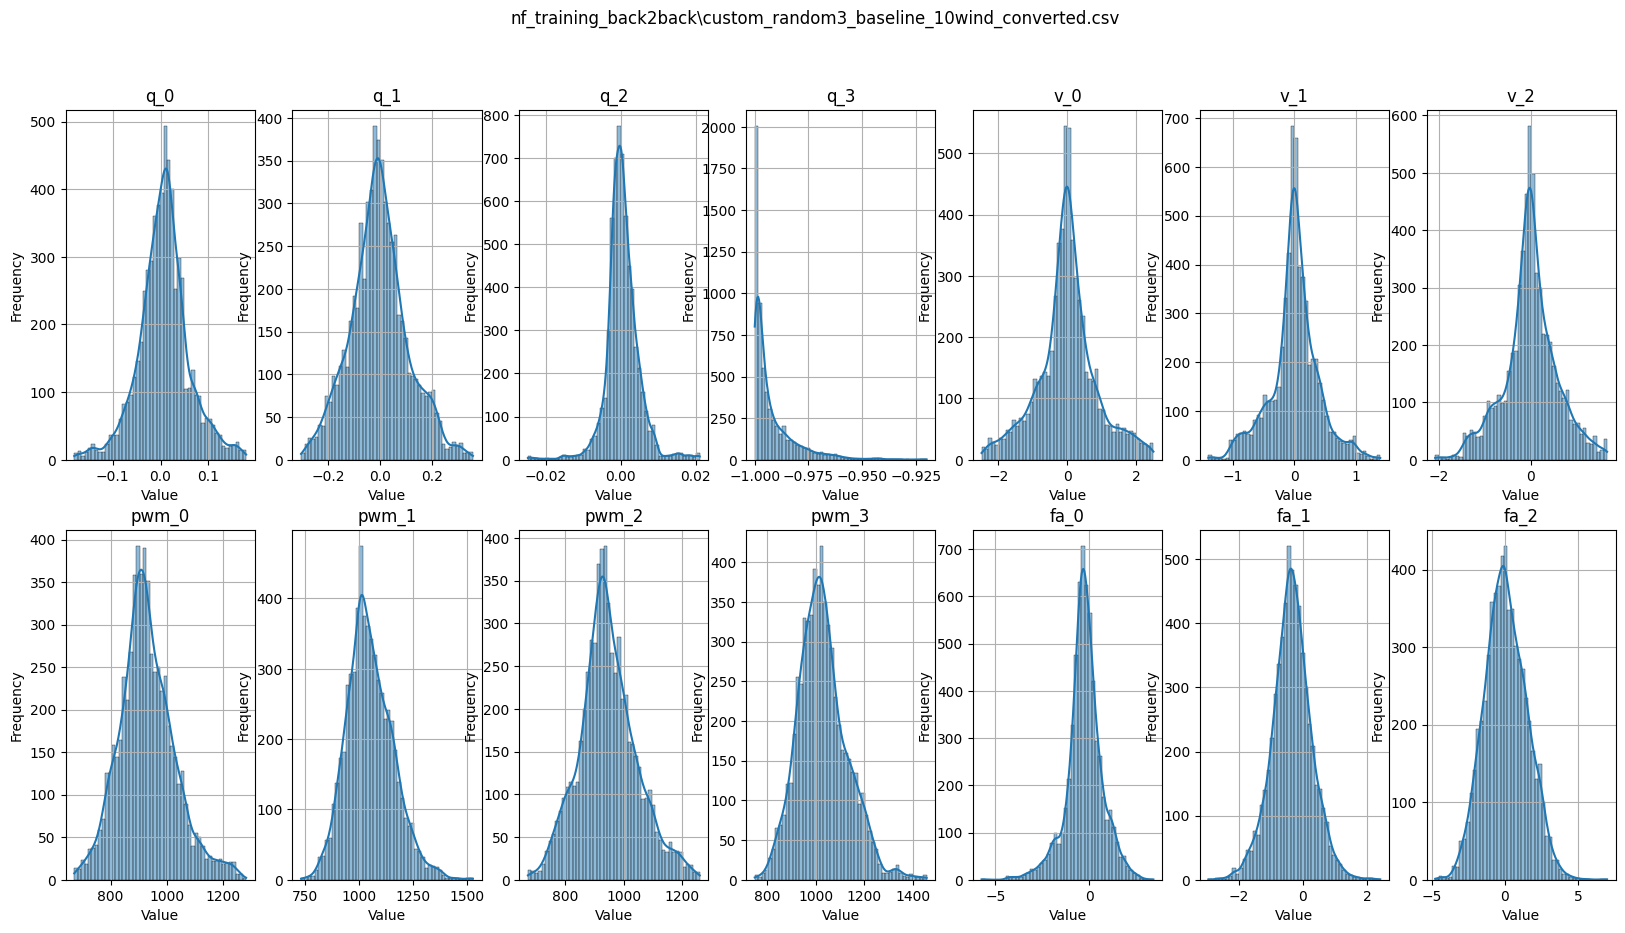

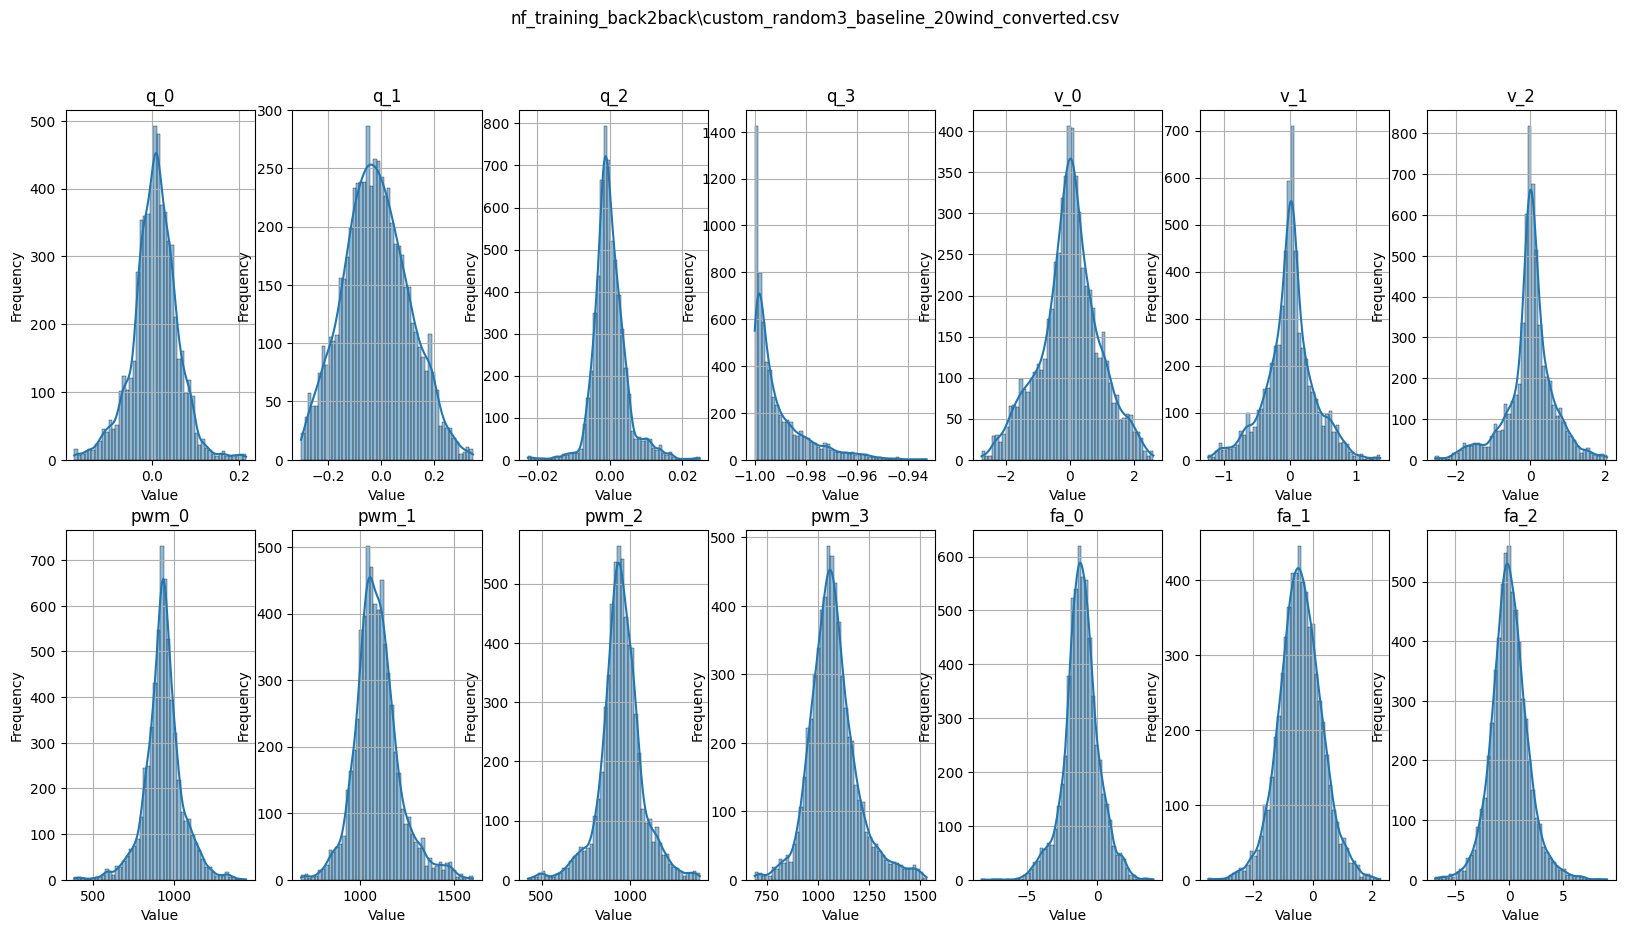

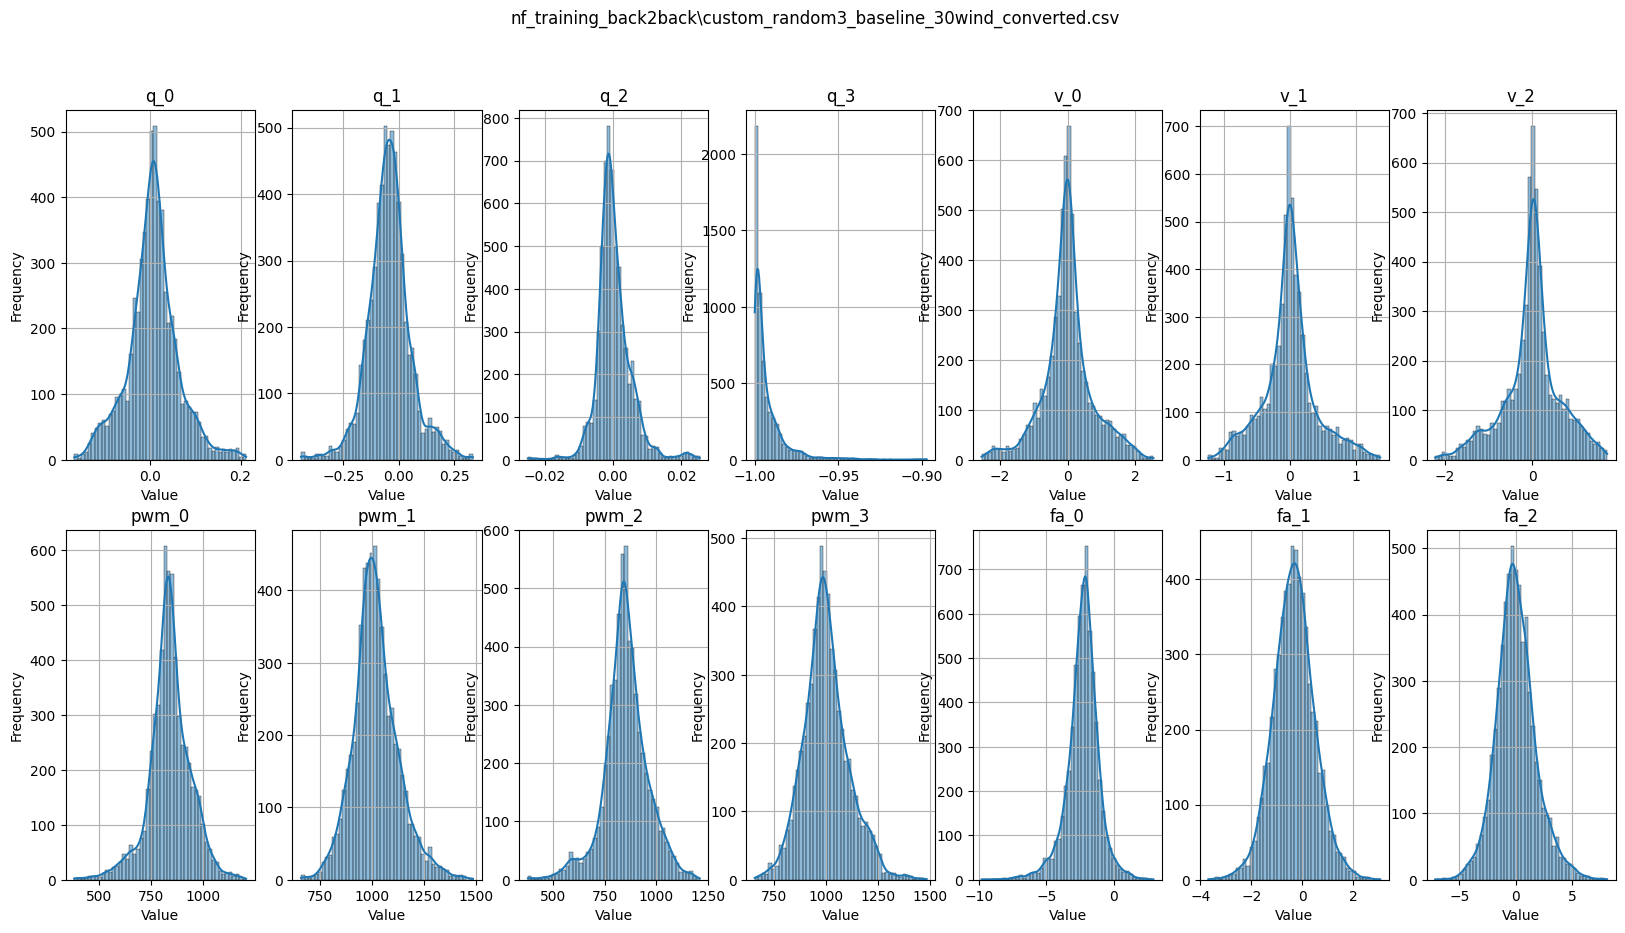

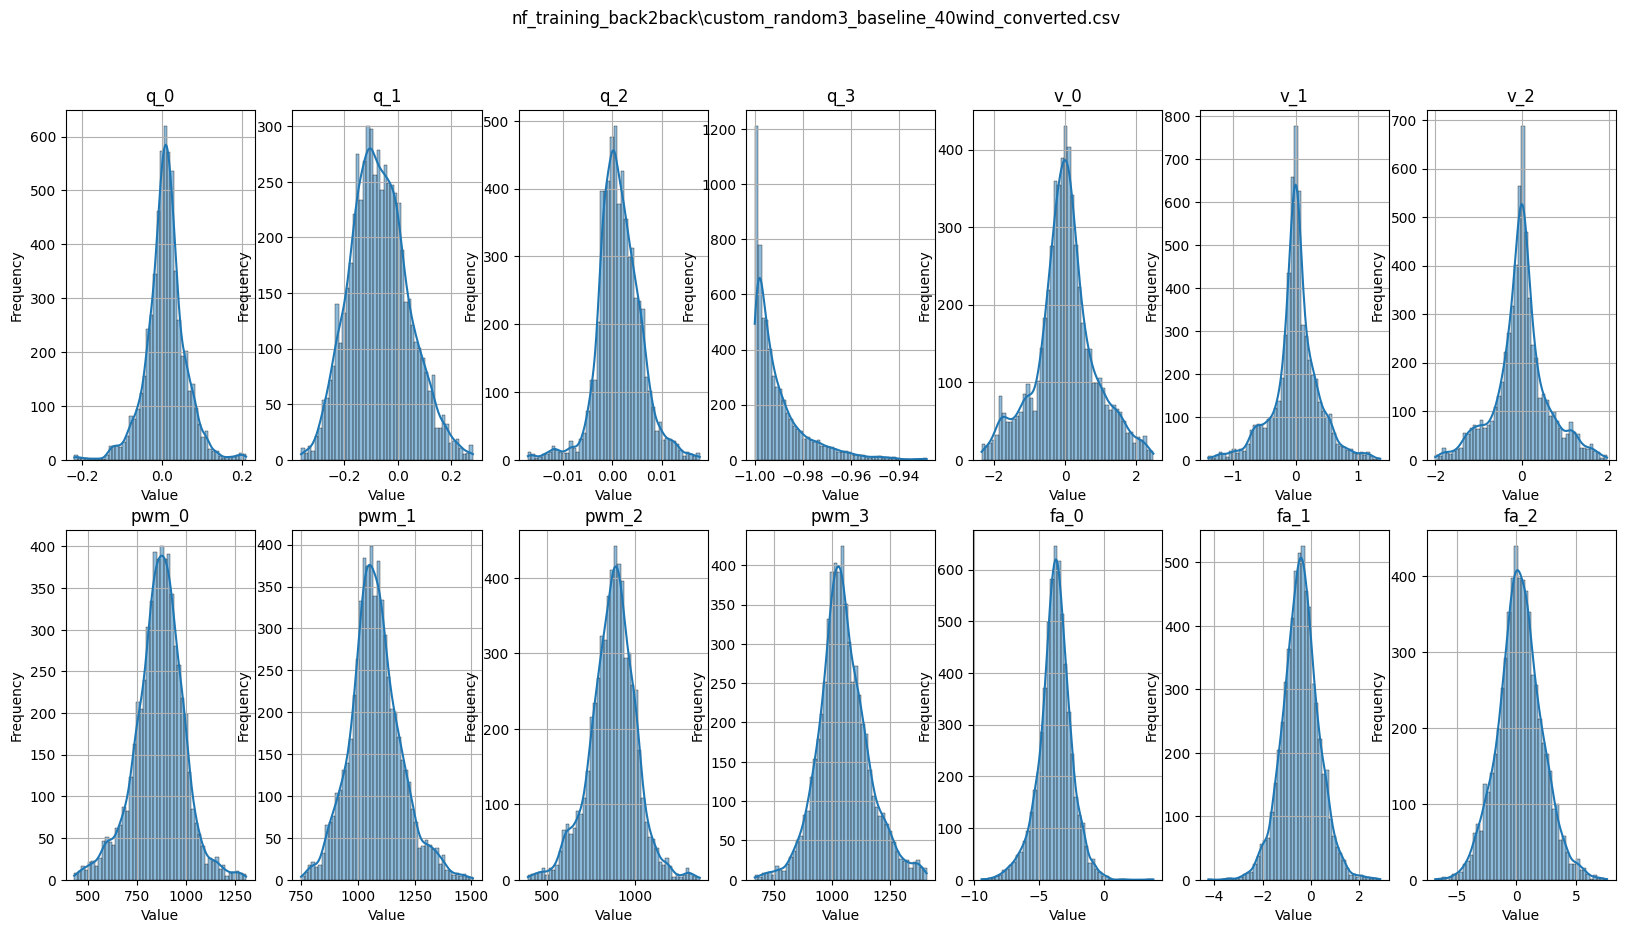

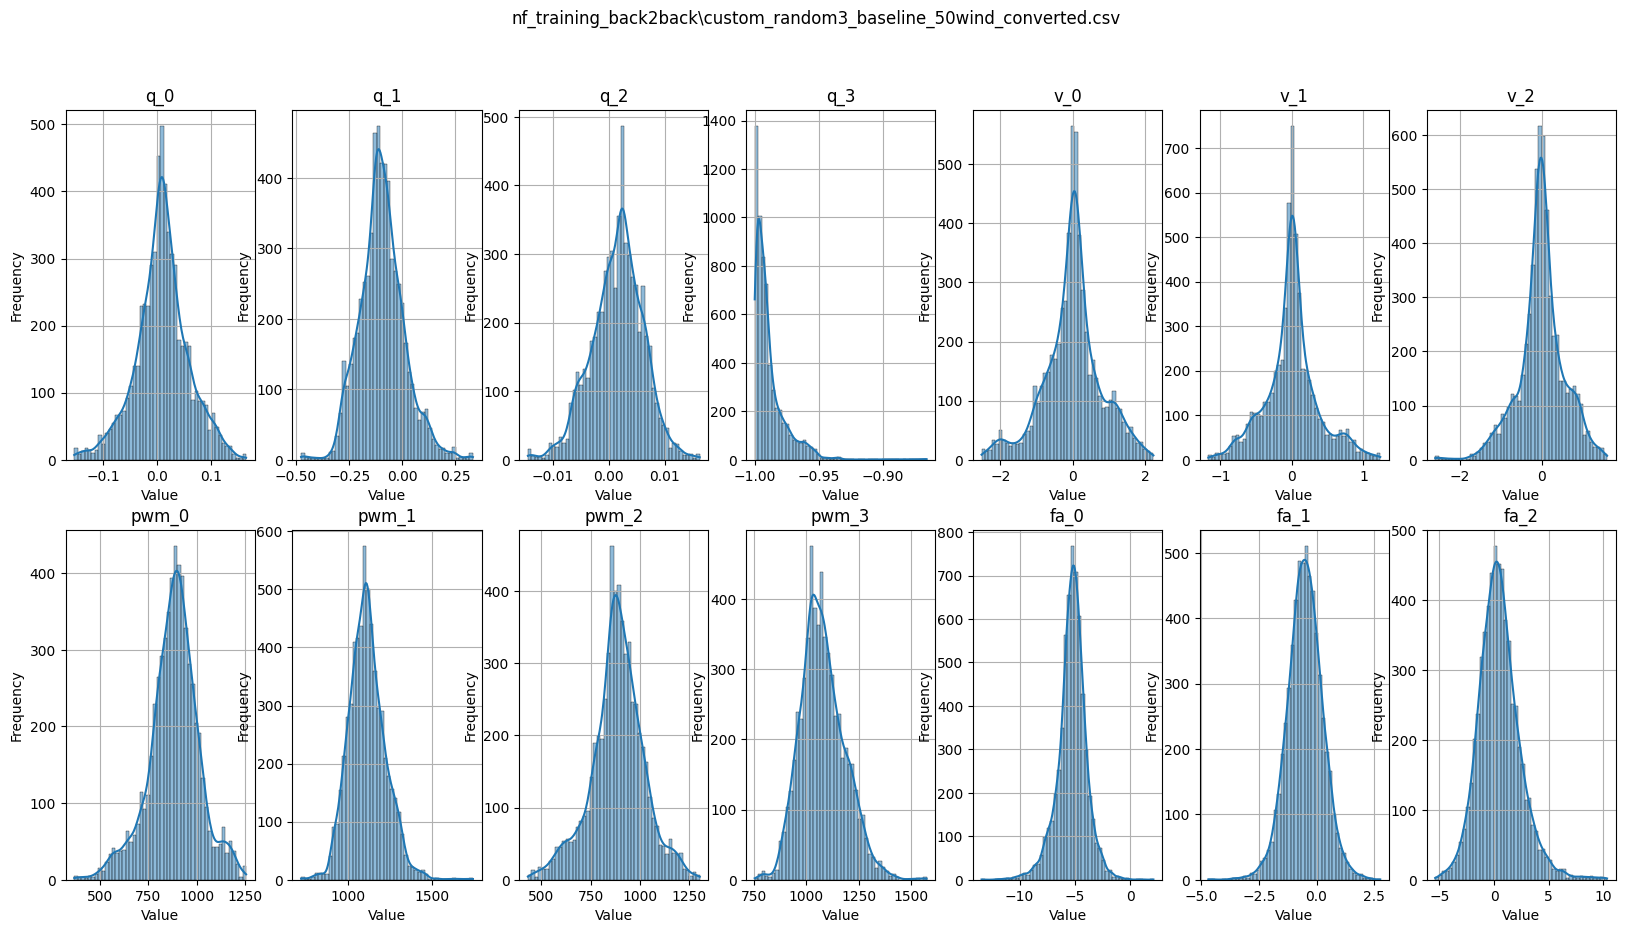

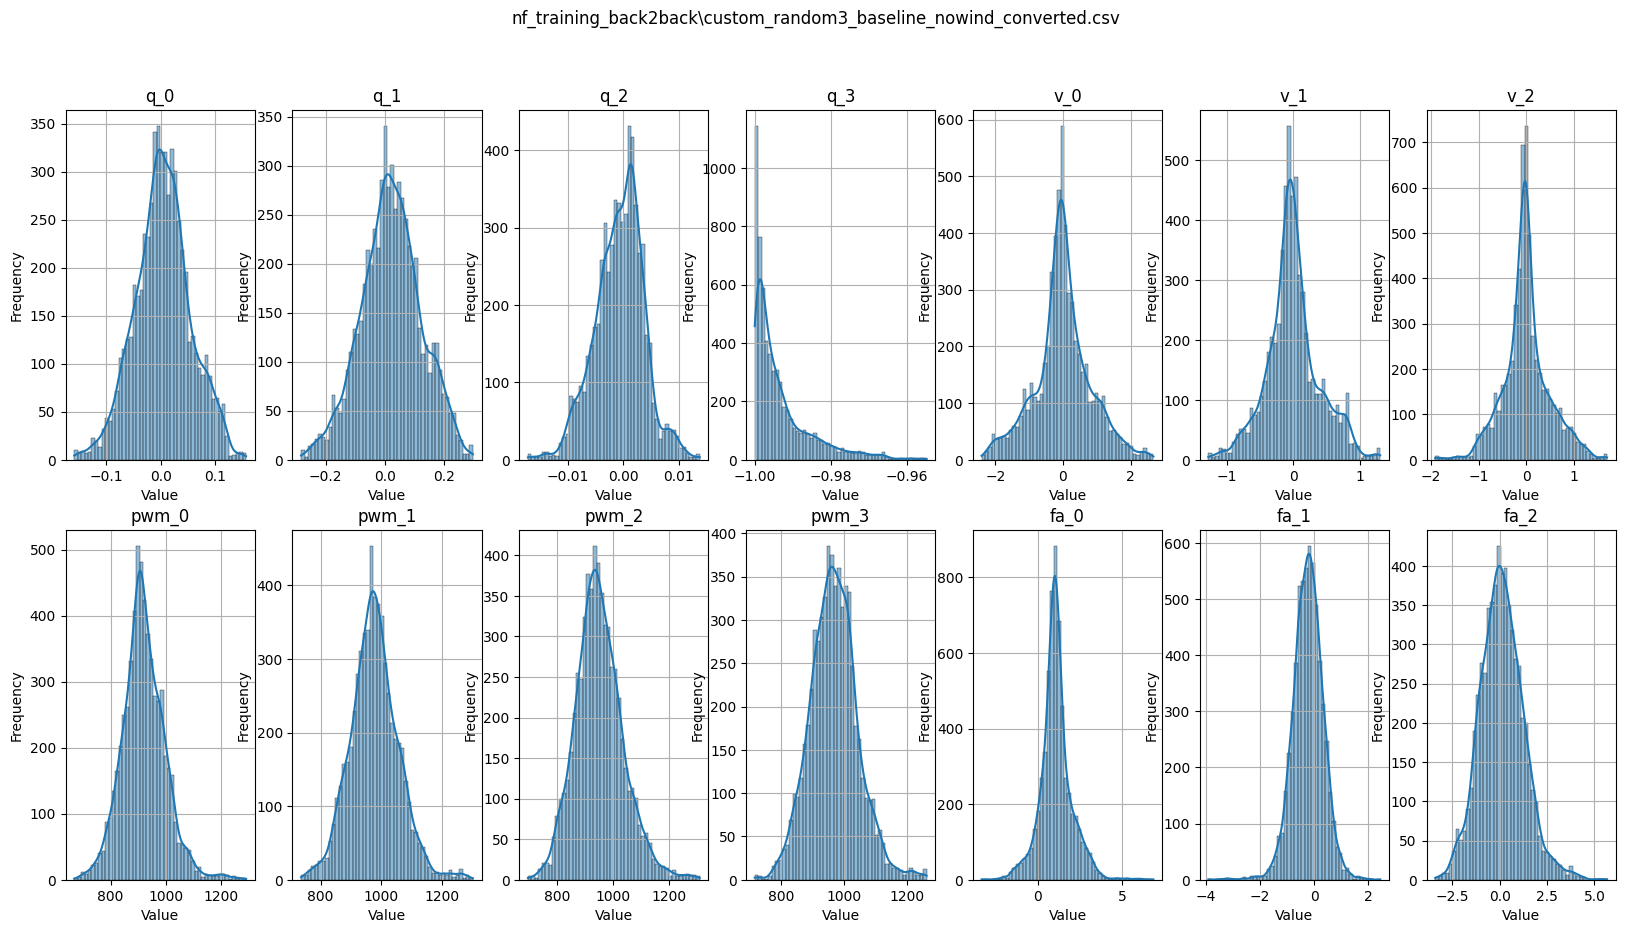

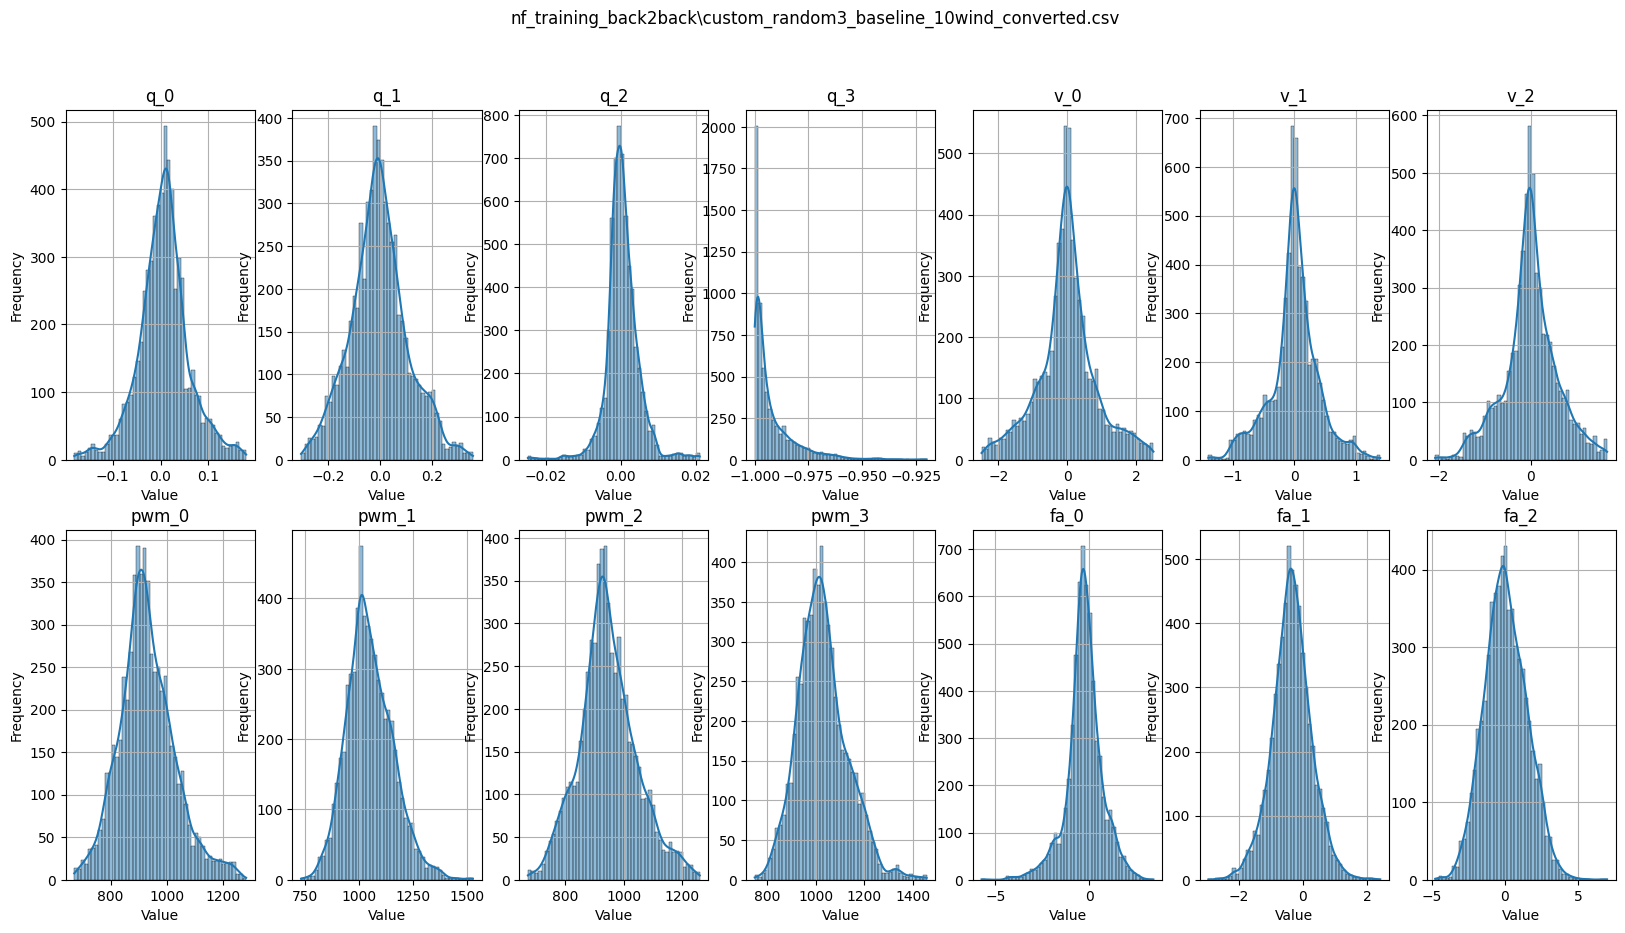

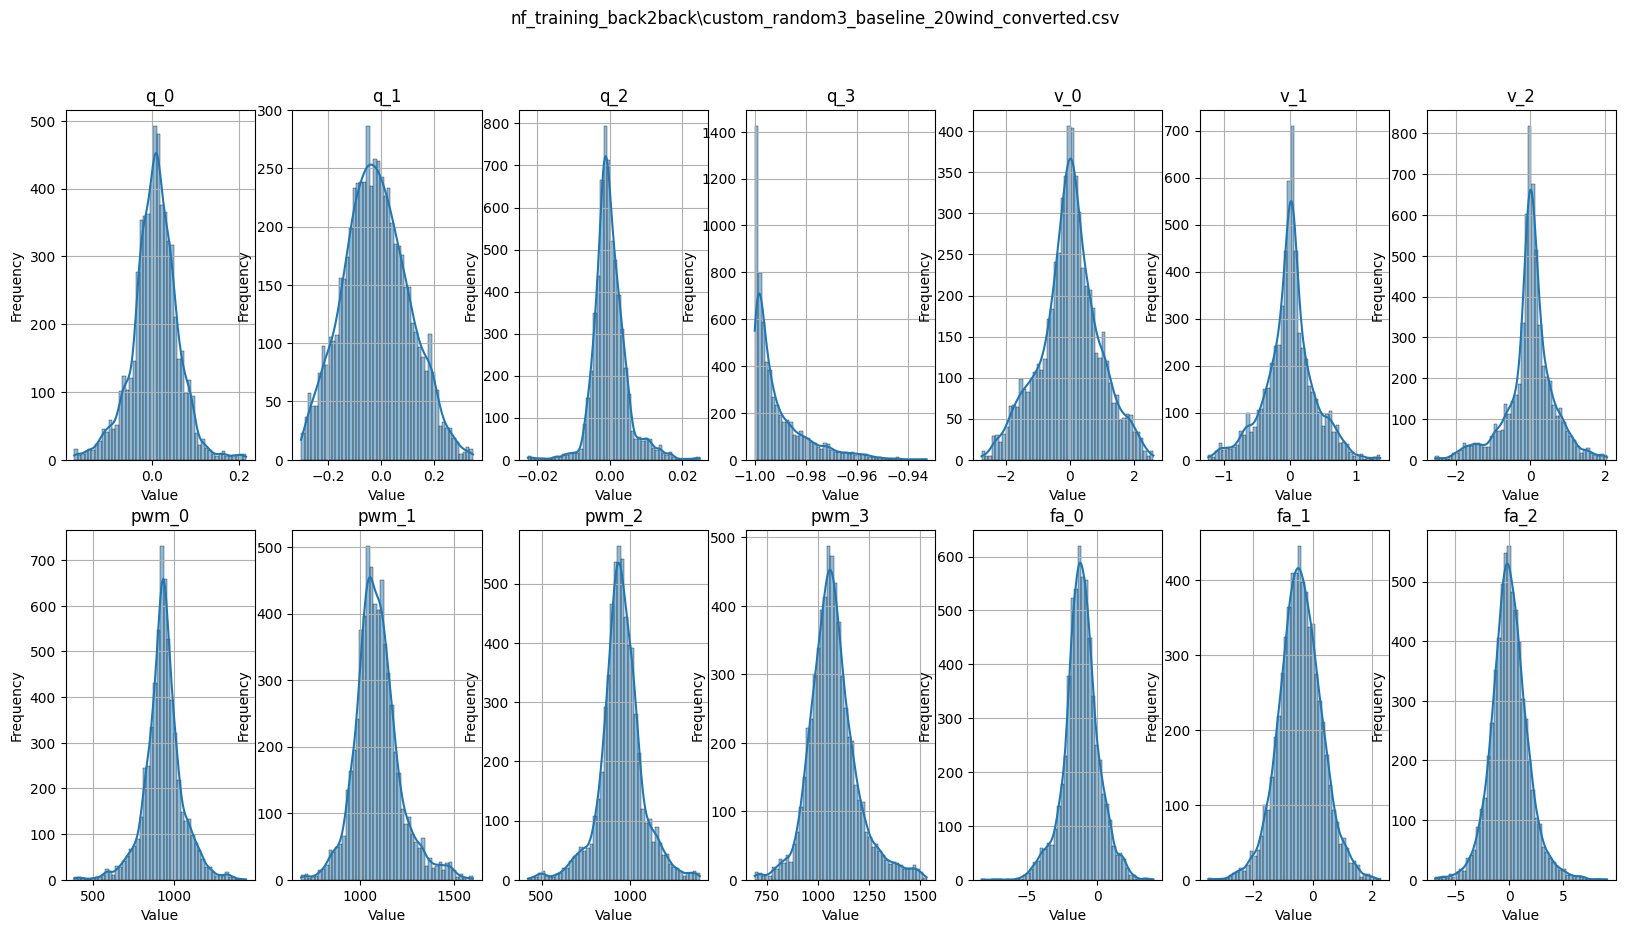

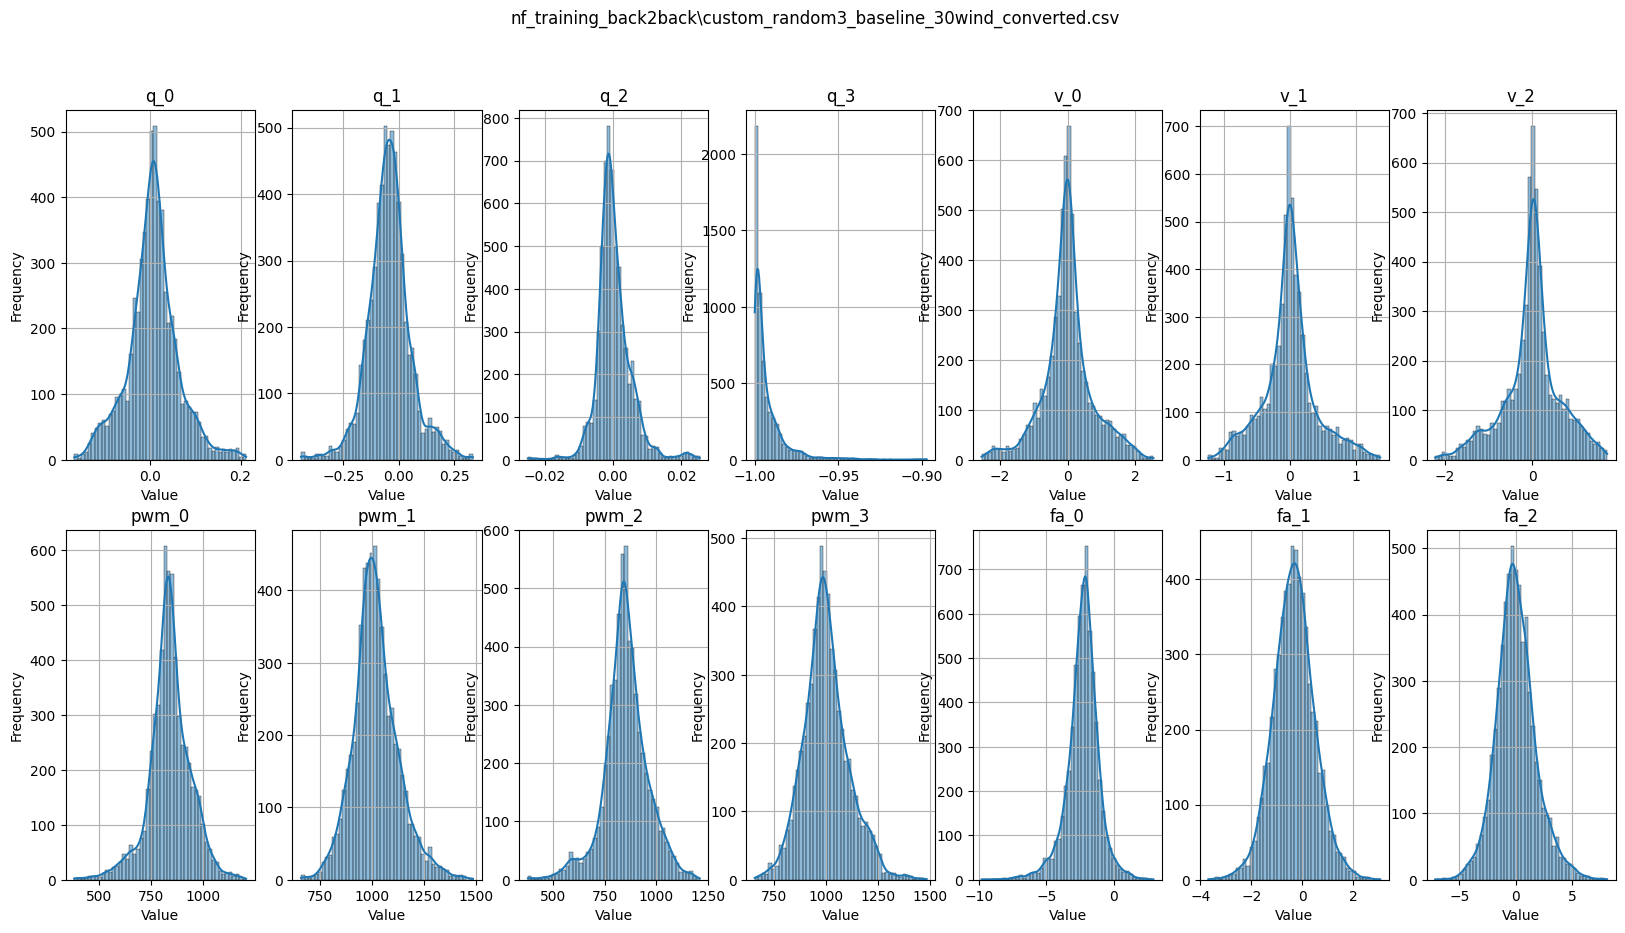

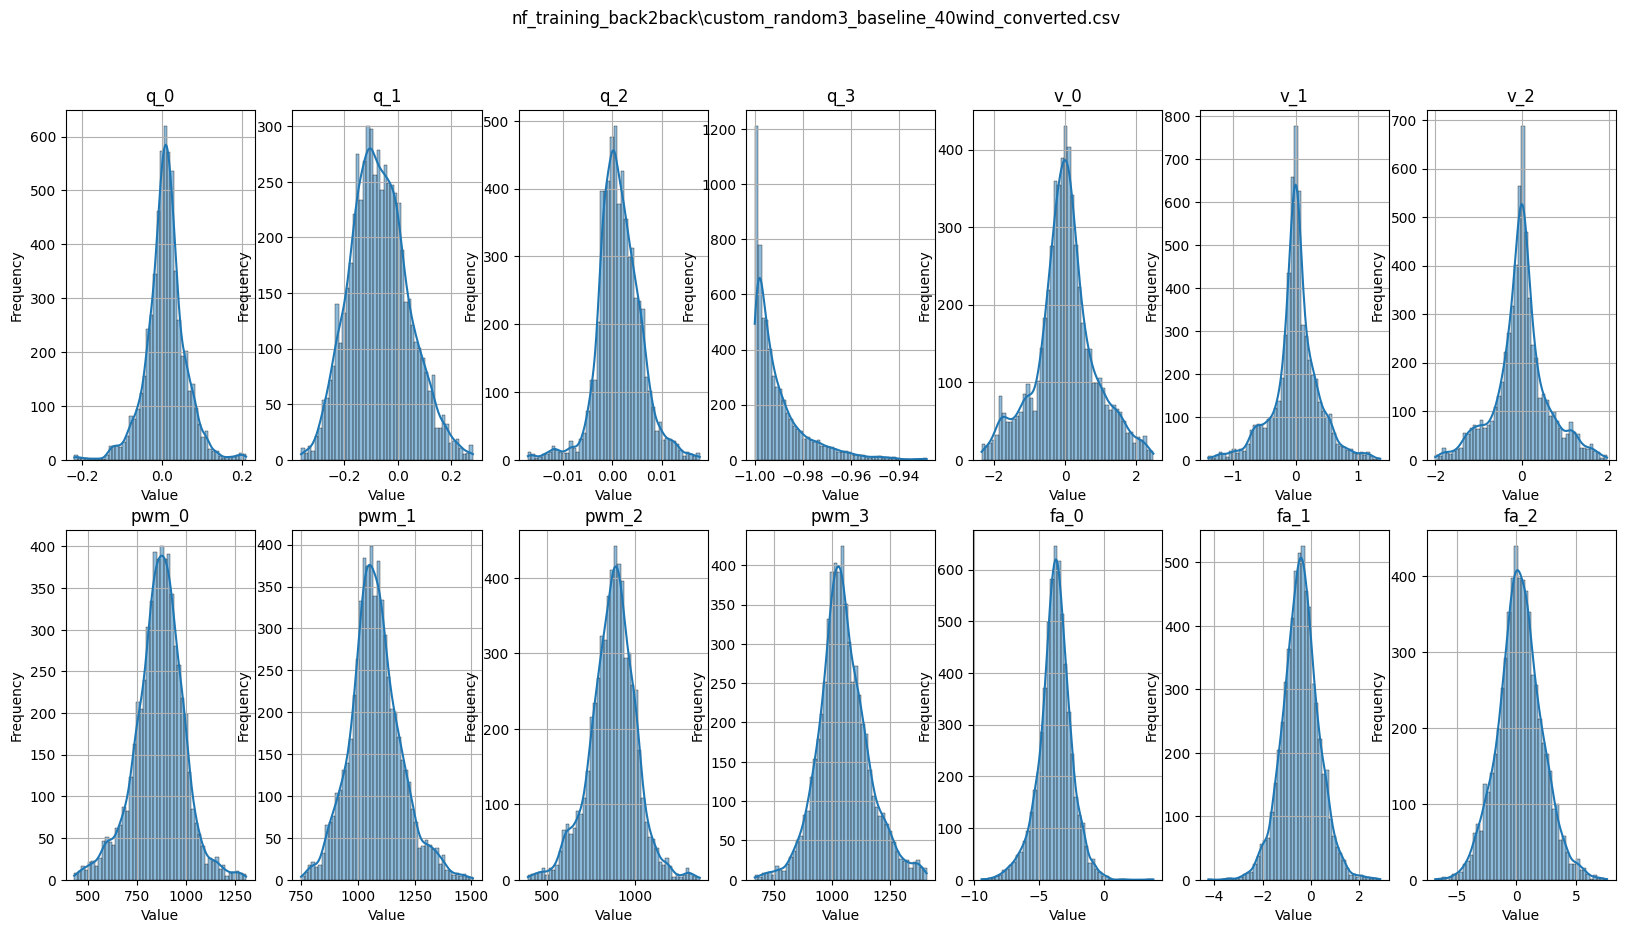

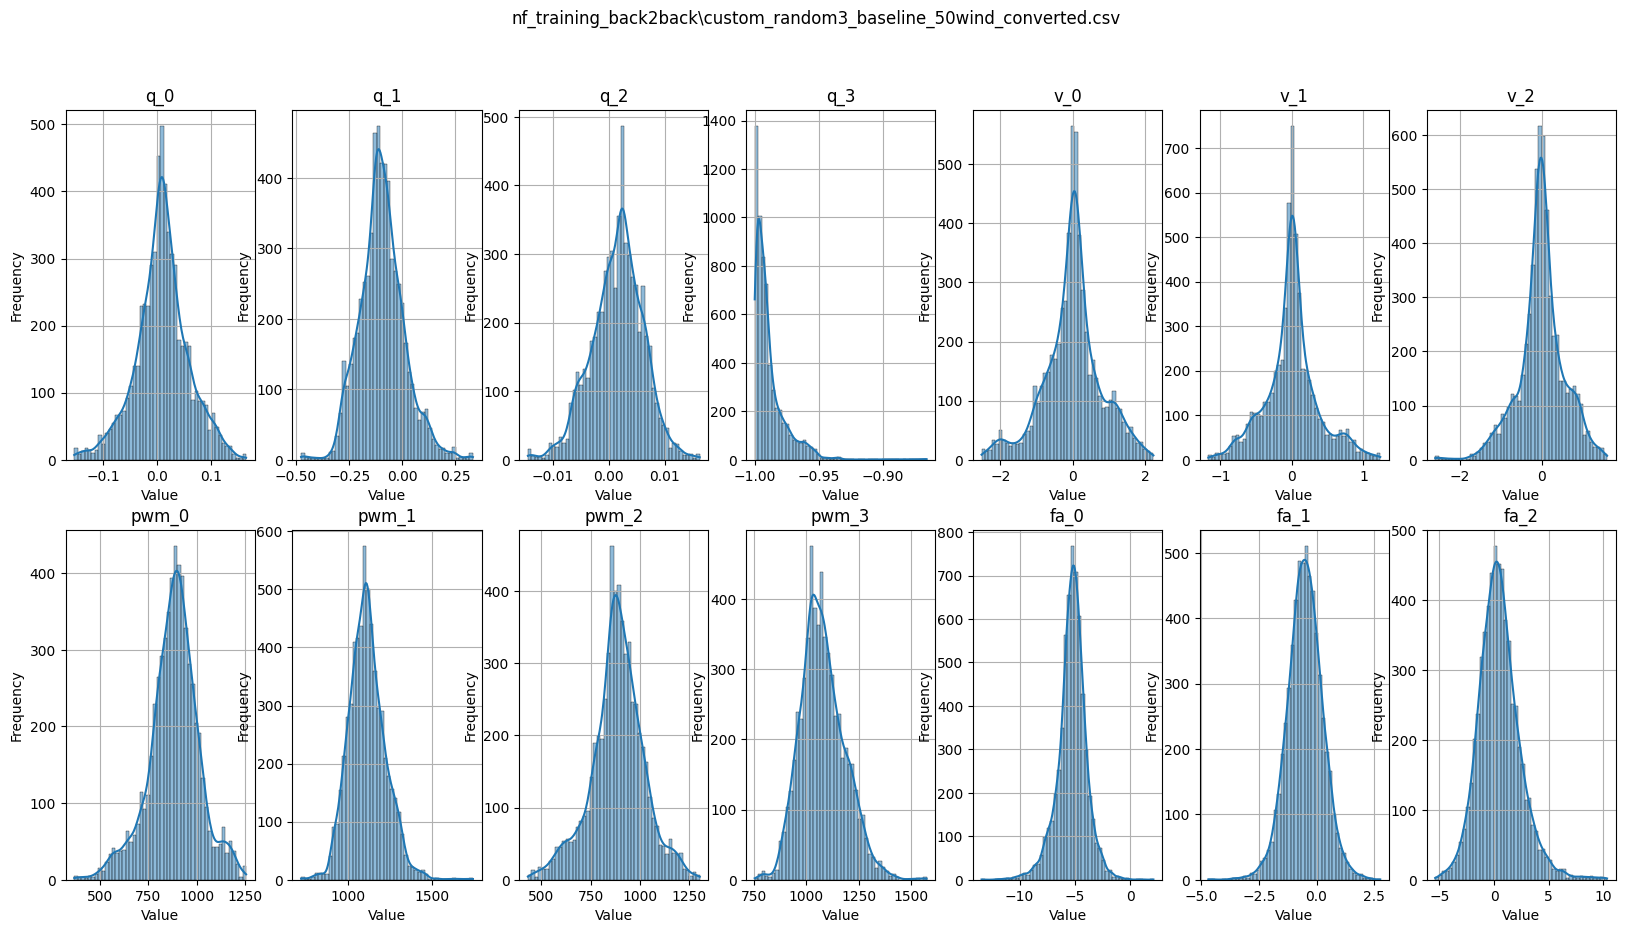

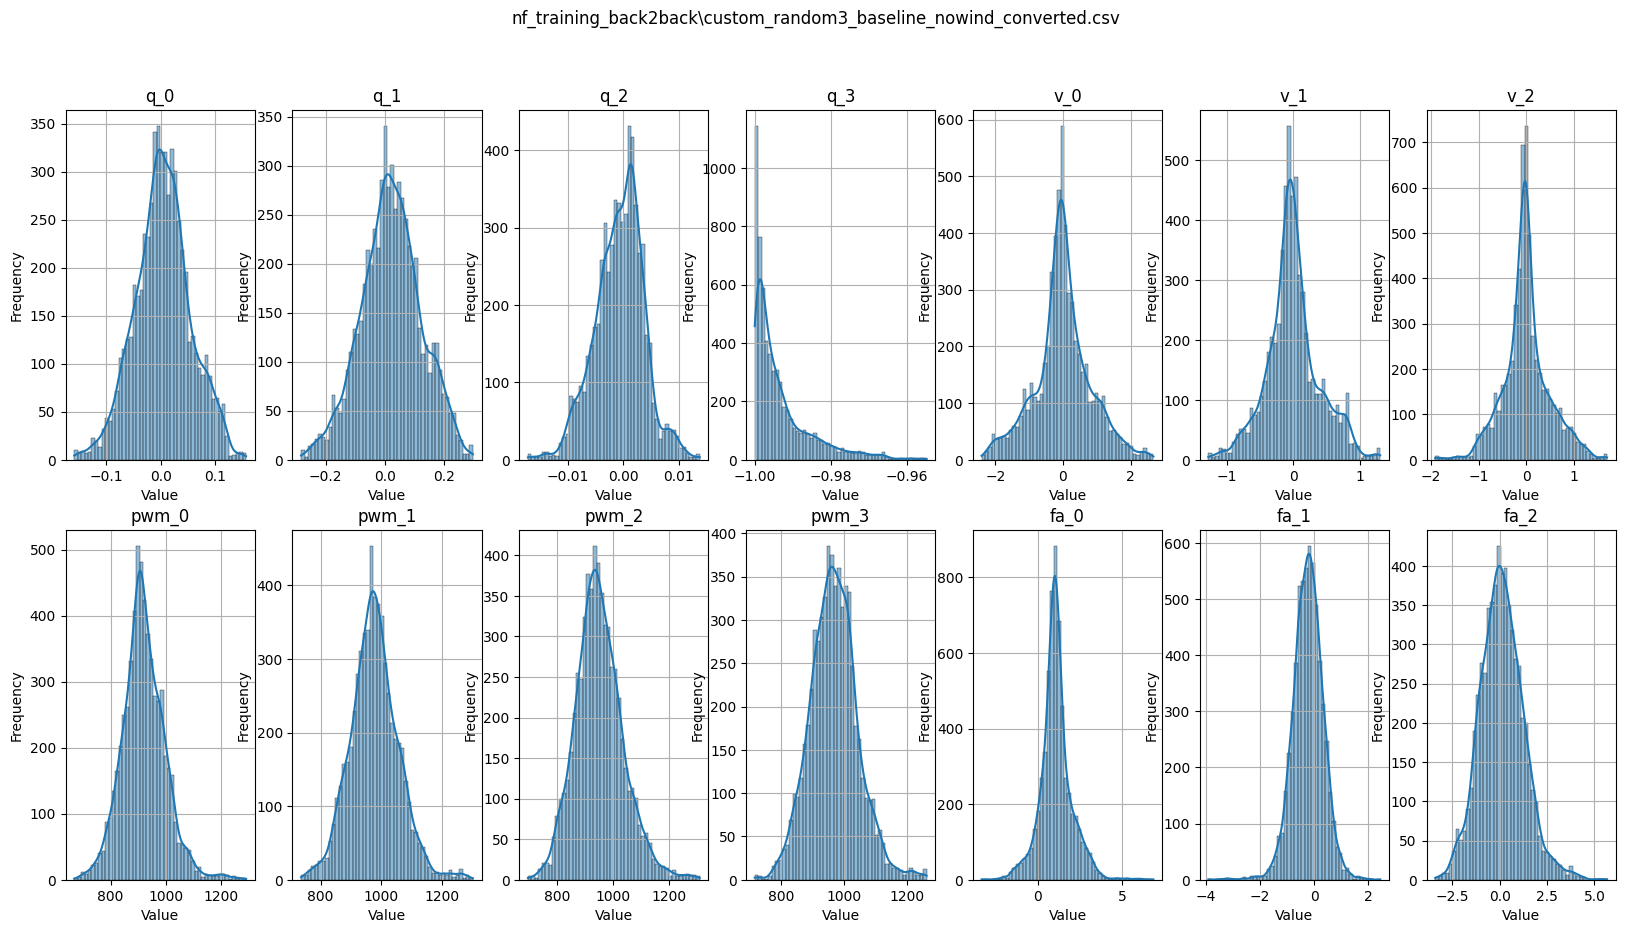

[1] loss_f: 3.67 loss_c: 1.83
[101] loss_f: 1.07 loss_c: 1.80


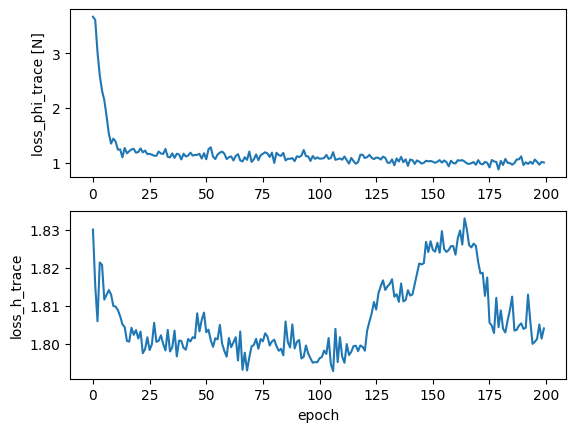

In [2]:
# use the data from previous section to train the model

manager = training_manager.TrainingManager()
manager.set_up(
    data_menu=data_list,
    # data_menu=data_list[:4],    # use small data list for quick testing
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False
)
plt.show() 
manager.train()
manager.trainer_instance.plot_loss()

plt.show()  

Inspect data in the data list.

In [ ]:
# trainer_instance.inspect_data(data_list[:2])
manager.trainer_instance.plot_loss()

Inspect t-sne of a_trace.

In [ ]:
import performance_analyzer
can_print_3d = False
n = 100
performance_analyzer.plot_tsne_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))
plt.show()  
if can_print_3d:
    %matplotlib tk
    performance_analyzer.plot_tsne_3d_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))


After training, we can save the model in the following way.

In [3]:
model_name = subfolder
manager.save_model(model_name)

Model saved to model\nf_training_back2back.pth


Validate the model using the validation set.

nf_validation_back2back\custom_figure8_baseline_100wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_35wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_70p20sint_converted.csv
nf_validation_back2back\custom_figure8_baseline_70wind_converted.csv
nf_validation_back2back\custom_figure8_baseline_nowind_converted.csv
phi net input output fields:
input ['q_0', 'q_1', 'q_2', 'q_3', 'v_0', 'v_1', 'v_2', 'pwm_0', 'pwm_1', 'pwm_2', 'pwm_3']
label ['fa_0', 'fa_1', 'fa_2']
phi_out: tensor([[-0.0714, -0.1438,  0.1595,  1.0000],
        [-0.0718, -0.1406,  0.1588,  1.0000],
        [-0.0707, -0.1417,  0.1594,  1.0000],
        ...,
        [ 0.0393, -0.1437,  0.2886,  1.0000],
        [ 0.0392, -0.1438,  0.2907,  1.0000],
        [ 0.0396, -0.1445,  0.2908,  1.0000]])
a = tensor([[ 1.9344,  1.6321, -5.8599],
        [82.5302, -2.4738, 70.7136],
        [21.9263, -1.2542, 12.5153],
        [-7.4406, -0.9683,  4.3087]])
RMS: [1.62204955 0.72782277 2.23234839]


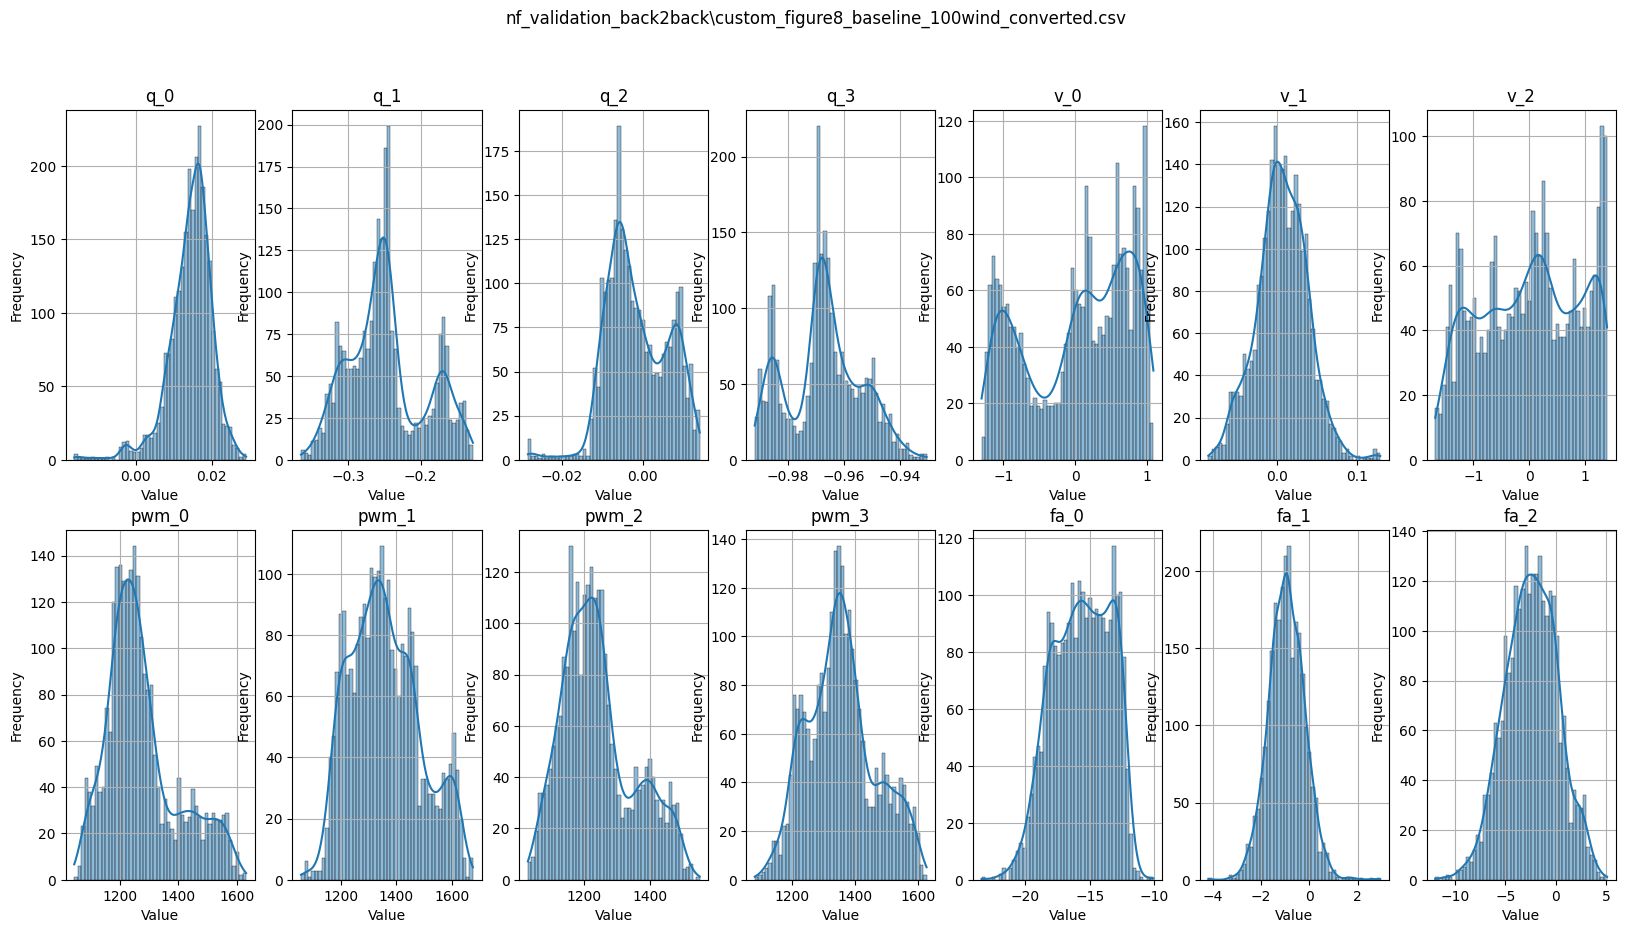

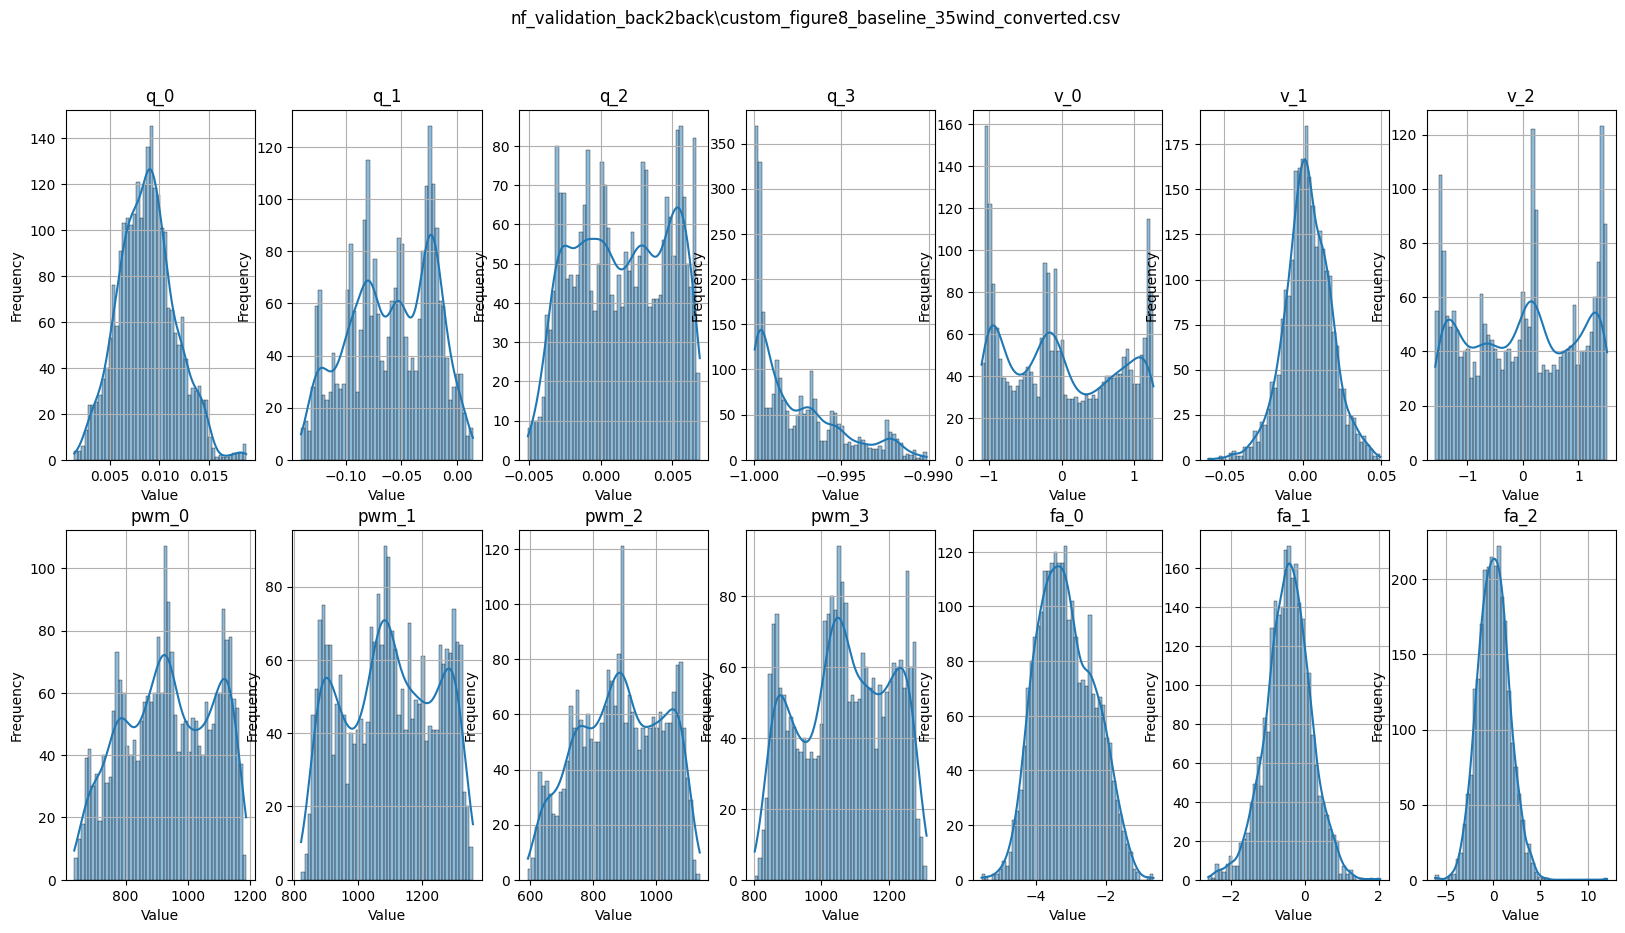

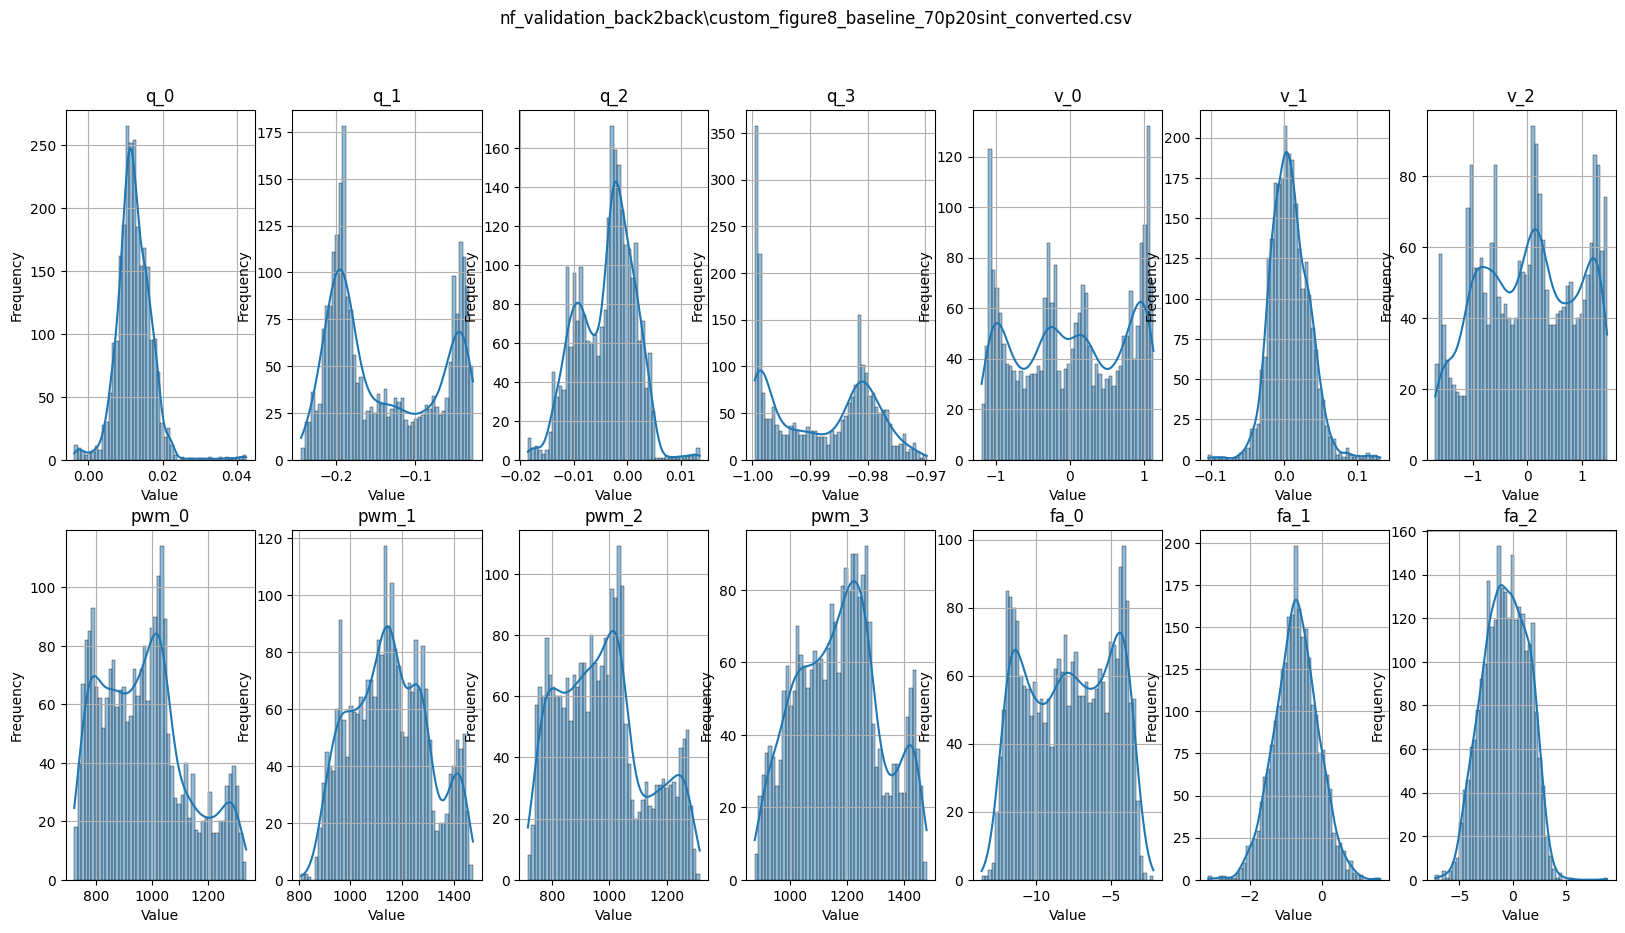

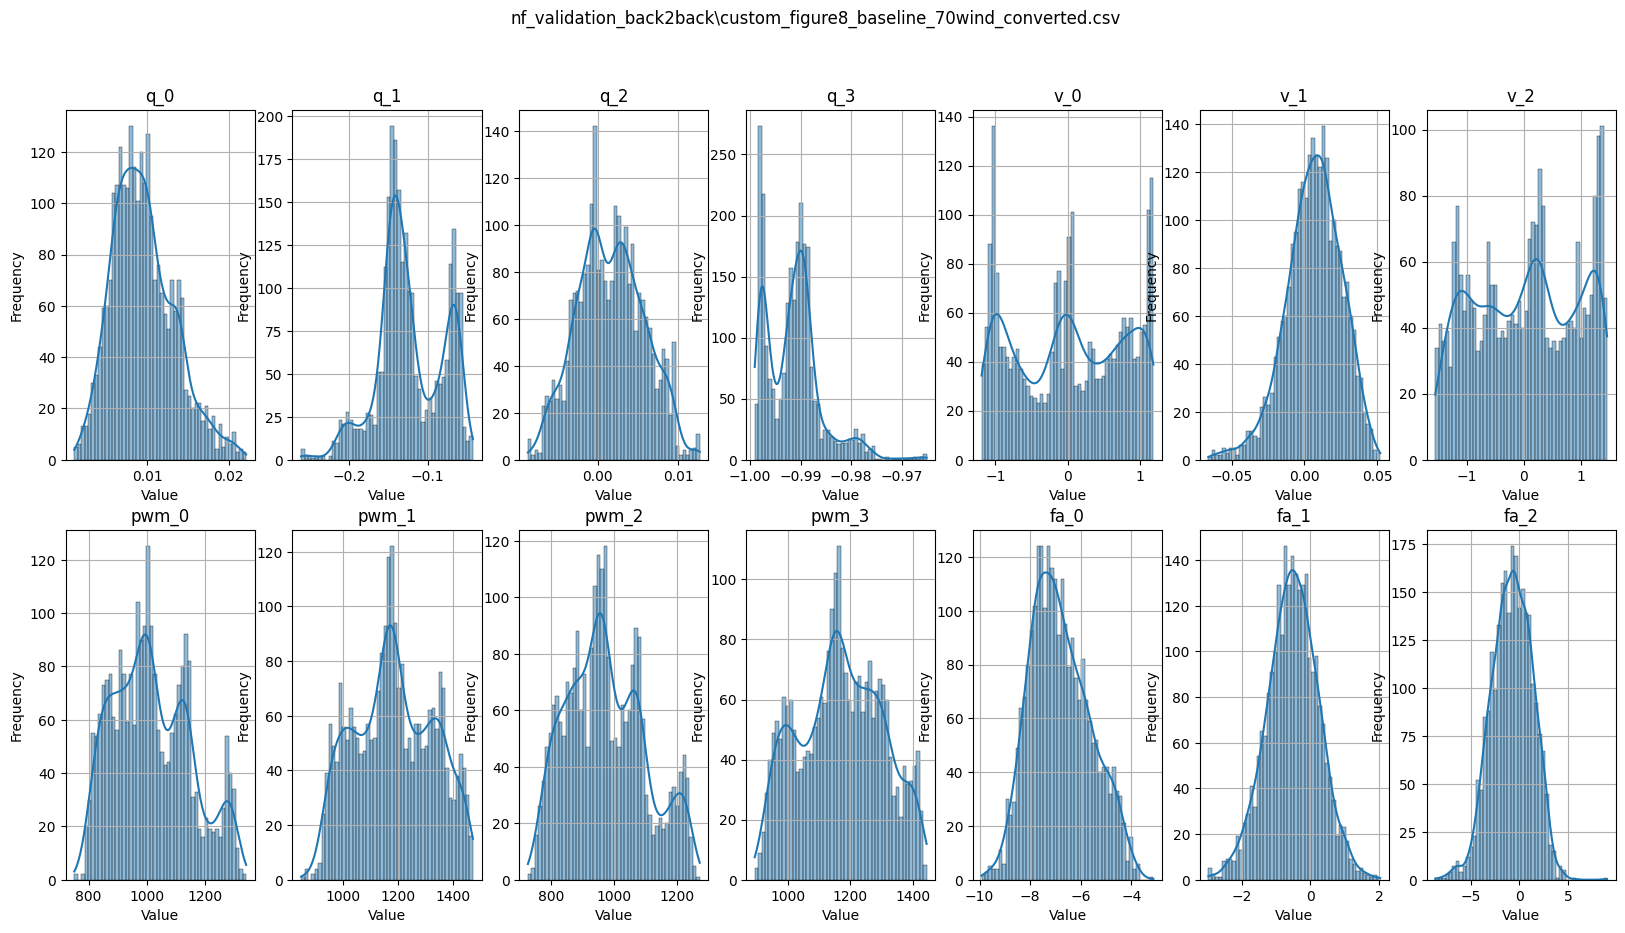

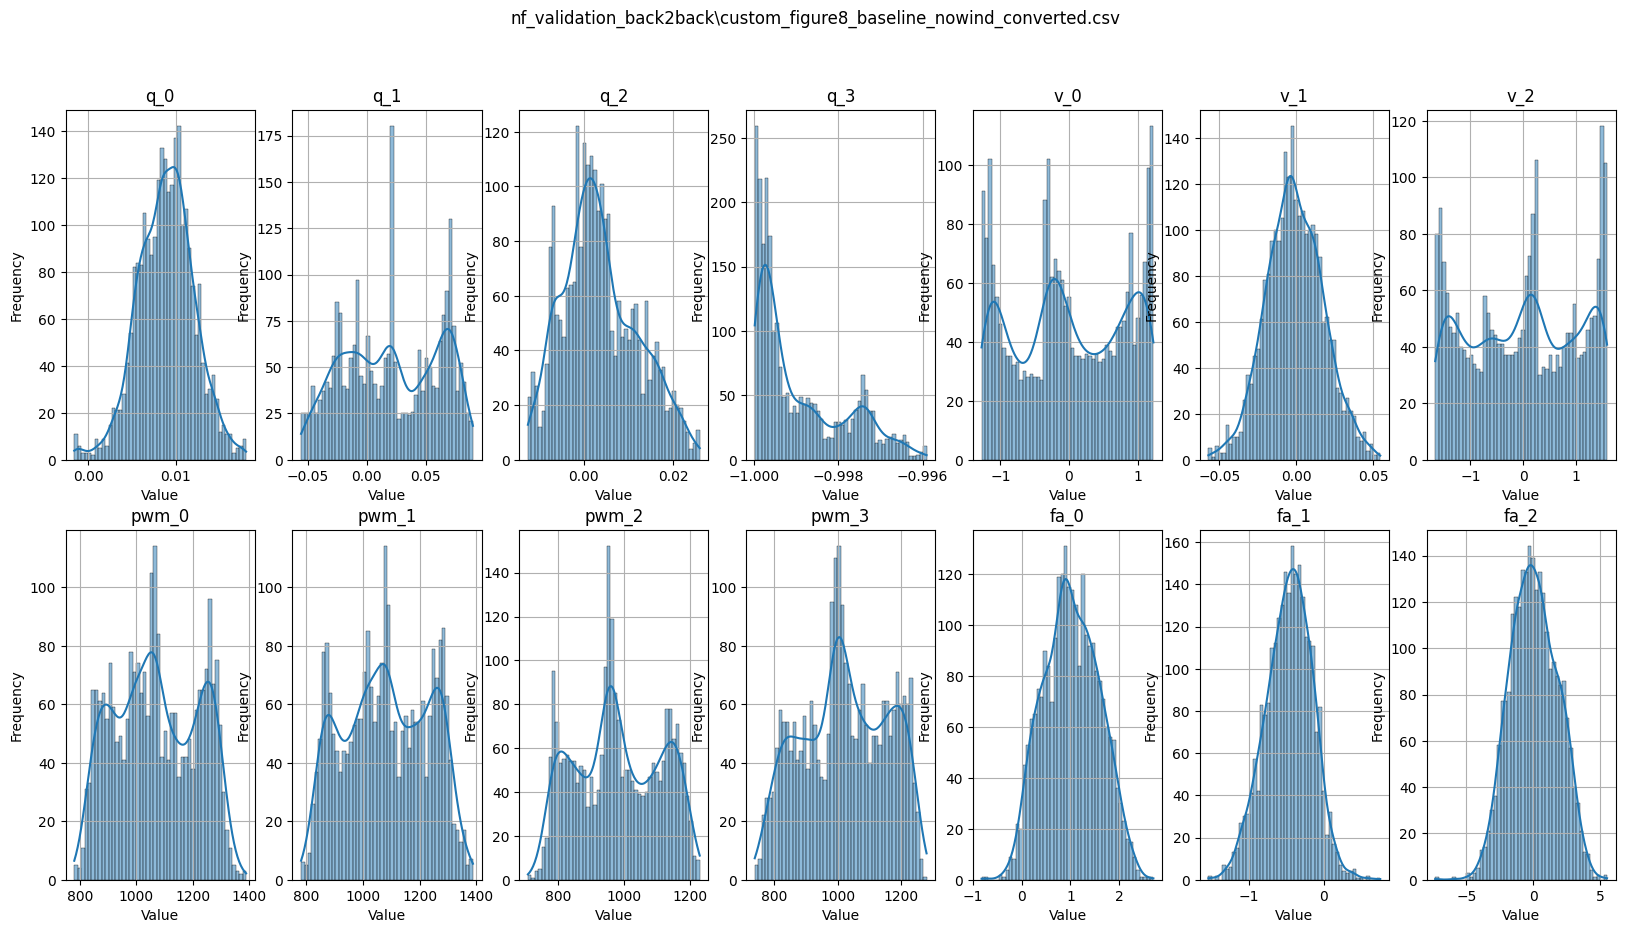

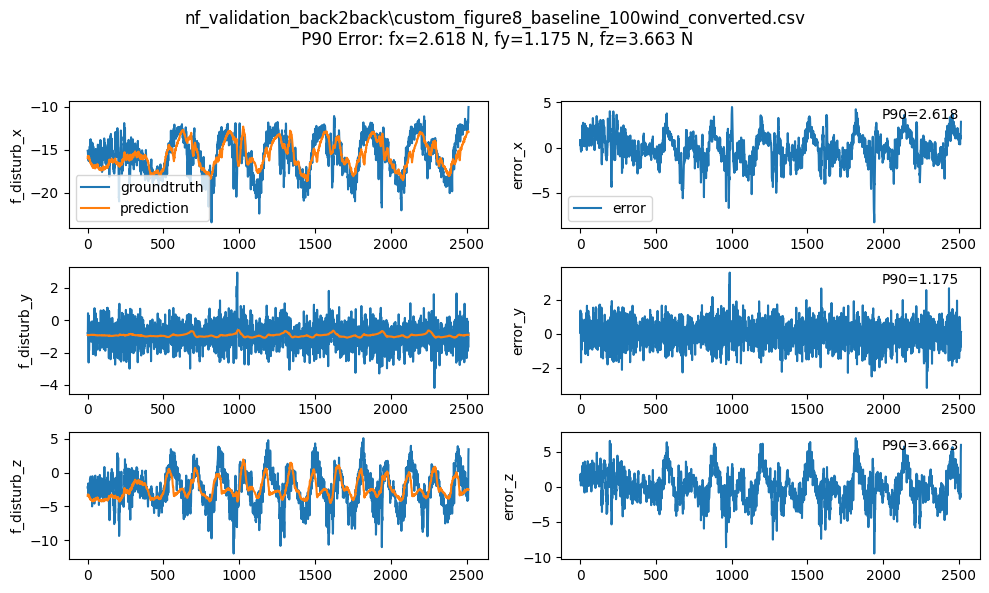

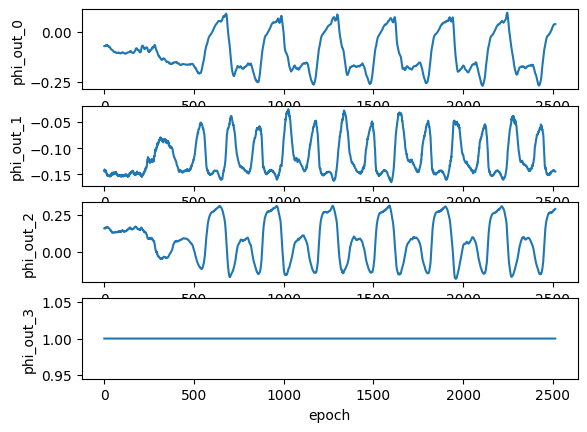

phi_out: tensor([[-0.1517, -0.1118,  0.0571,  1.0000],
        [-0.1533, -0.1123,  0.0554,  1.0000],
        [-0.1527, -0.1129,  0.0574,  1.0000],
        ...,
        [ 0.0074, -0.1360,  0.2346,  1.0000],
        [ 0.0078, -0.1362,  0.2350,  1.0000],
        [ 0.0084, -0.1361,  0.2360,  1.0000]])
a = tensor([[ 2.3143,  0.1822,  2.4274],
        [10.2941, -1.4083, -6.1778],
        [ 4.9123, -0.3568, -4.3470],
        [-1.8847, -0.5409, -0.0660]])
RMS: [0.52574207 0.61213359 1.618211  ]


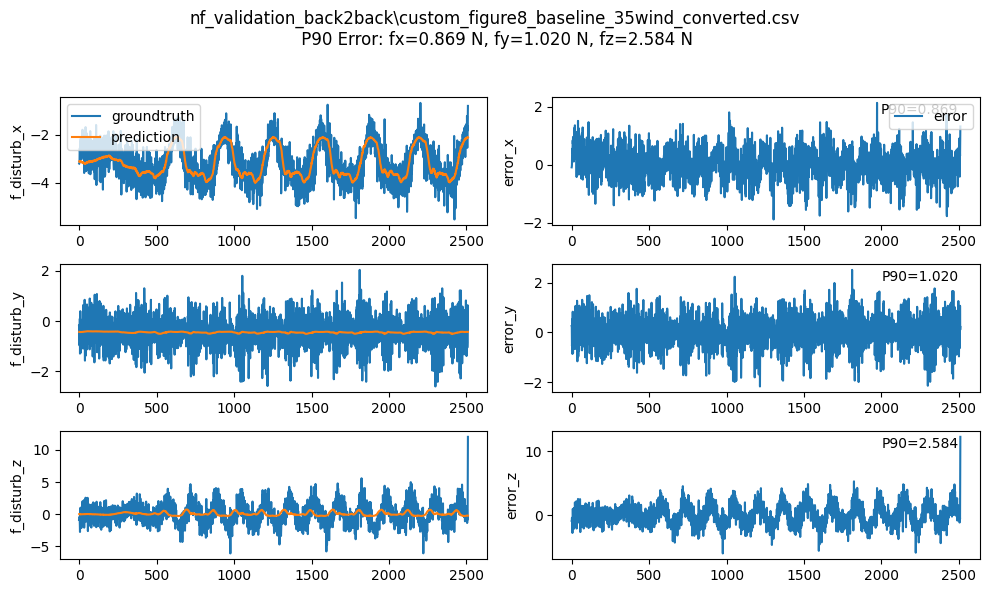

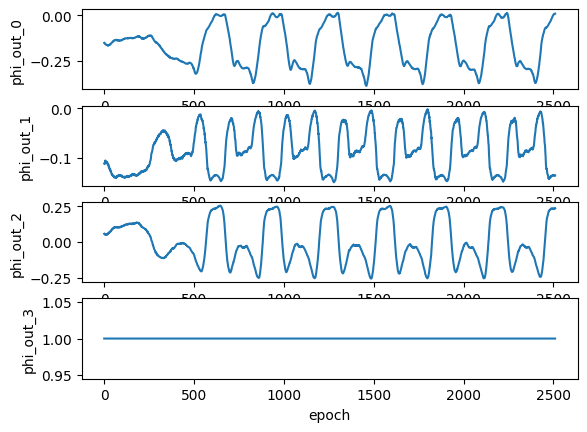

phi_out: tensor([[-0.1198, -0.1166,  0.0753,  1.0000],
        [-0.1205, -0.1176,  0.0737,  1.0000],
        [-0.1218, -0.1186,  0.0752,  1.0000],
        ...,
        [ 0.0023, -0.1368,  0.2451,  1.0000],
        [ 0.0023, -0.1364,  0.2479,  1.0000],
        [ 0.0020, -0.1362,  0.2498,  1.0000]])
a = tensor([[ -7.8670,  -0.2685,  -7.7457],
        [119.9930,   2.9305,  81.1985],
        [ 40.3584,   0.8647,  21.0568],
        [  2.0418,  -0.4797,   5.8854]])
RMS: [2.14299668 0.61307619 1.76169858]


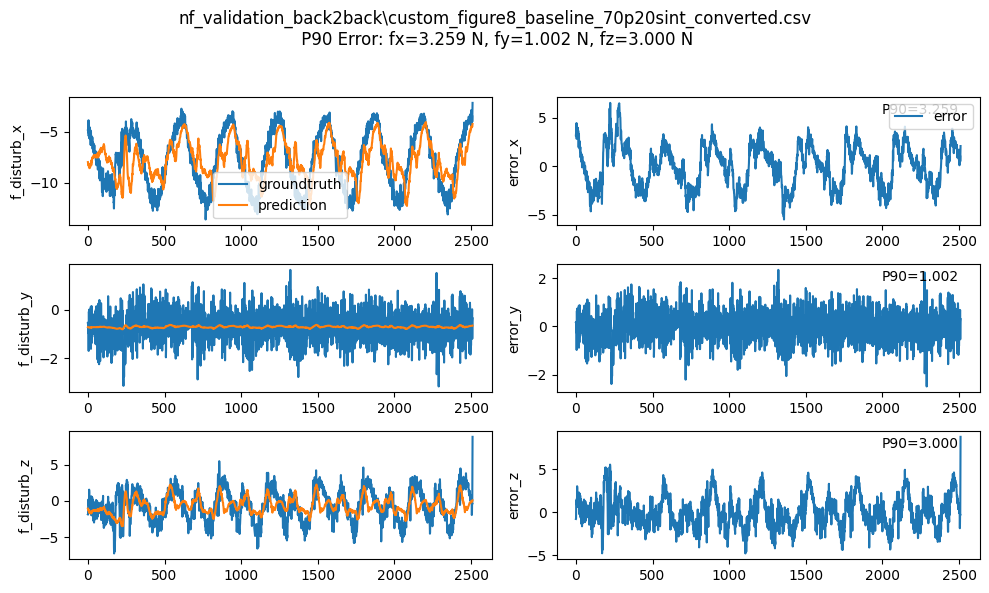

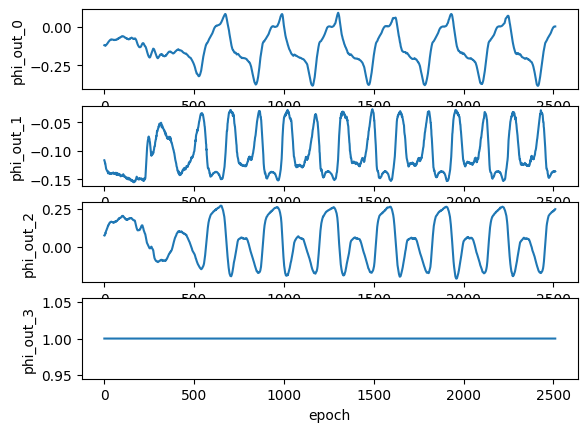

phi_out: tensor([[-0.1299, -0.1285,  0.0971,  1.0000],
        [-0.1325, -0.1281,  0.0915,  1.0000],
        [-0.1325, -0.1261,  0.0943,  1.0000],
        ...,
        [ 0.0085, -0.1391,  0.2572,  1.0000],
        [ 0.0077, -0.1393,  0.2576,  1.0000],
        [ 0.0072, -0.1394,  0.2585,  1.0000]])
a = tensor([[ 2.5035,  0.1493,  1.7885],
        [35.8104, -1.7516, 26.4857],
        [11.9919, -0.1559,  2.2763],
        [-3.2837, -0.6625,  2.0590]])
RMS: [0.75576093 0.74825576 1.93824176]


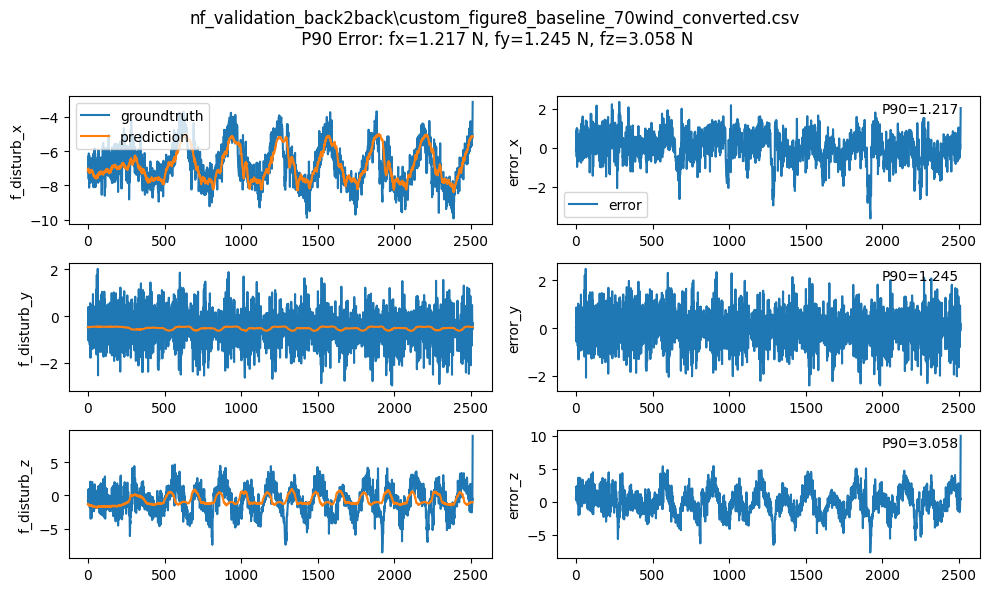

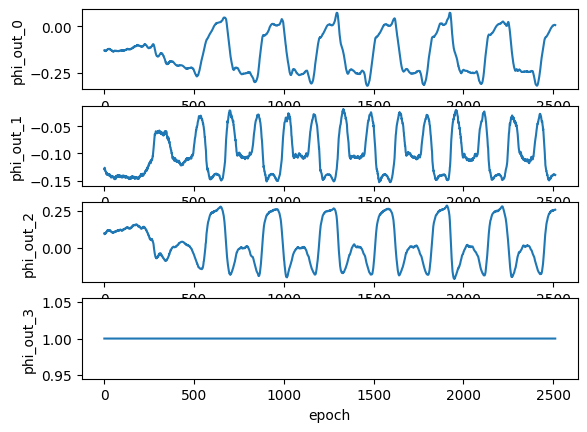

phi_out: tensor([[-0.1861, -0.1001,  0.0174,  1.0000],
        [-0.1862, -0.1017,  0.0191,  1.0000],
        [-0.1863, -0.1013,  0.0190,  1.0000],
        ...,
        [ 0.0106, -0.1308,  0.2239,  1.0000],
        [ 0.0113, -0.1310,  0.2241,  1.0000],
        [ 0.0109, -0.1317,  0.2230,  1.0000]])
a = tensor([[ 2.3437e+00, -1.1628e-01, -7.3203e-01],
        [ 1.3942e+01, -3.8268e-01,  6.3285e+00],
        [ 3.7151e+00,  3.9613e-03,  3.3403e+00],
        [ 2.6061e+00, -5.1698e-01,  4.4654e-01]])
RMS: [0.40032964 0.31021308 1.7500251 ]


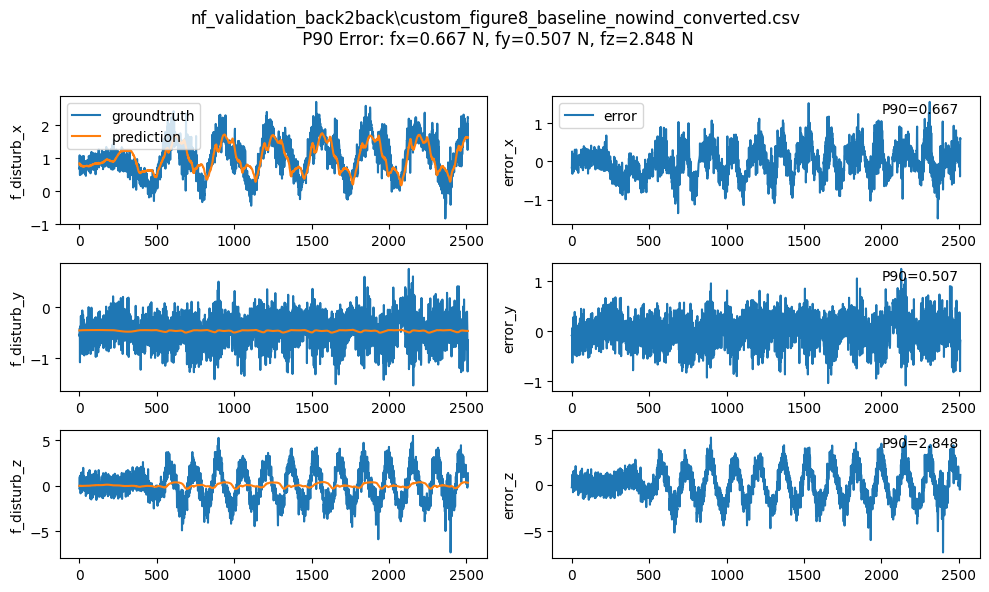

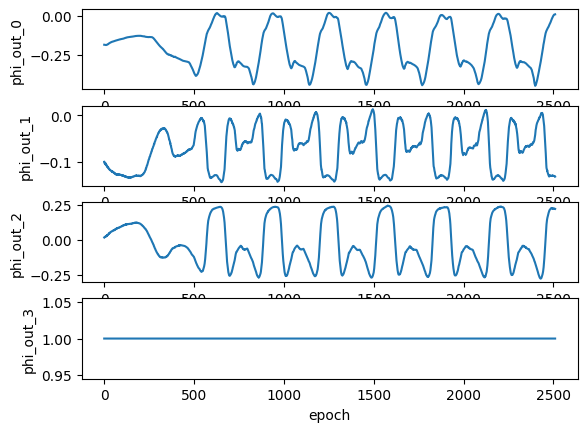

In [5]:
current_dir = os.getcwd()
# subfolder = "wind_near_wall_validation_no_bemt"
subfolder = "nf_validation_back2back"
folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Filter out files that do not end with .csv
file_names = [f for f in file_names if f.endswith('.csv')]
# add subfolder to the file names
data_list = [os.path.join(subfolder, f) for f in file_names]
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

phi, h = training_manager.load_model(model_name)
# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.validate(phi, h, data_list)
plt.show()  
